In [1]:
import pandas as pd
import seaborn as sn
import torch
import time
from torch import nn, optim
import plotly.express as px
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix

import torch.nn.functional as F

from confusion import cm

In [2]:
class PathwayScores(Dataset):

    def __init__(self, csv_file):
        """Initializes instance of class PathwayScores.

        Args:
            csv_file (str): Path to the csv file with the data.

        """
        self.df = pd.read_csv(csv_file, sep='\t')
        self.df = self.df[self.df["PAM50"] != "NC"]

        # Grouping variable namesdict( enumerate(train['PAM50'].cat.categories ) ) 
        self.features = ['Cell_Cycle', 'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53', 'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2']
        self.target = "PAM50"
        
        self.df['PAM50'] = self.df['PAM50'].astype('category')
        self.df['PAM50'] = self.df['PAM50'].cat.codes.values

        # Save target and predictors
        self.X = self.df.loc[:, self.features].values
        self.y = self.df.loc[:, self.target].values

        self.transform = transforms.Compose([transforms.ToTensor()]) 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [self.transform(self.X.iloc[idx].values), self.transform(self.y[idx])]


In [3]:
class Net(nn.Module):

  def __init__(self, n_features):

    super(Net, self).__init__()

    self.fc1 = nn.Linear(n_features, 200)

    self.fc2 = nn.Linear(200, 120)

    self.fc3 = nn.Linear(120, 84)

    self.fc4 = nn.Linear(84, 4)

    self.drop = nn.Dropout(p=0.2)

  def forward(self, x):

    x = F.relu(self.fc1(x))

    x = F.relu(self.fc2(x))

    x = self.drop(x)

    x = F.relu(self.fc3(x))

    return self.fc4(x)


In [16]:
train = "data/generated/train_augmented.csv"
test = "data/generated/test.csv"
train = pd.read_csv(train)
test = pd.read_csv(test)
train["PAM50"].unique()

array(['LumA', 'LumB', 'Her2', 'Basal'], dtype=object)

In [5]:
train = "data/generated/train.csv"
test = "data/generated/test.csv"
train = pd.read_csv(train)
test = pd.read_csv(test)
train["PAM50"].unique()

array(['LumA', 'LumB', 'Her2', 'Basal'], dtype=object)

In [6]:
train.columns

Index(['submitter', 'B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils', 'Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2', 'PAM50', 'age_at_diagnosis',
       'PROLIF', 'RFS', 'RFSE', 'DSSE10', 'DSS10', 'grade', 'stage',
       'lymph_nodes_positive', 'Treatment', 'TP53.mut', 'PIK3CA.mut', 'NPI',
       'CELLULARITY', 'INTCLUST'],
      dtype='object')

In [17]:
train['PAM50'] = train['PAM50'].astype('category')
train['PAM50'] = train['PAM50'].cat.codes.values

In [18]:
X_train = train[['Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2','PROLIF','grade','stage']]
y_train = train["PAM50"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=47)

In [20]:
X_train = X_train.to_numpy(dtype=float)
y_train = y_train.to_numpy()
X_test = X_test.to_numpy(dtype=float)
y_test = y_test.to_numpy()

In [21]:
len(X_train)

2244

In [22]:
def batch_generator(idata, target, batch_size, shuffle=True):
    nsamples = len(idata)
    if shuffle:
        perm = np.random.permutation(nsamples)
    else:
        perm = range(nsamples)

    for i in range(0, nsamples, batch_size):
        batch_idx = perm[i:i+batch_size]
        if target is not None:
            yield idata[batch_idx], target[batch_idx]
        else:
            yield idata[batch_idx], None

In [23]:
def train(model, criterion, optimizer, X_data, y_data, batch_size, log=False):
    model.train()
    total_loss = 0
    total_acc = 0
    ncorrect = 0
    niterations = 0
    conf = [[0] * 4] * 4 

    for X, y in batch_generator(X_data, y_data, batch_size, shuffle=True):
        
        # Get input and target sequences from batch
        X_train = torch.FloatTensor(X)
        y_train = torch.LongTensor(y)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        conf += confusion_matrix(y_train, torch.max(y_pred, 1)[1], labels = [0,1,2,3])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(y_pred, 1)[1] == y_train).sum().item()
        #print(str((torch.max(y_pred, 1)[1] == y_train).sum().item()) +"/"+str(len(X_train)))
        niterations += 1
    
    #print(str(ncorrect) + "/" + str(len(X_data)) + "=" + str(ncorrect/len(X_data)))
    total_acc = ncorrect/len(X_data)*100

    return total_loss, total_acc, conf

In [24]:
def val(model, criterion, optimizer, X_data, y_data, batch_size, log=False):
    model.eval()
    total_loss = 0
    total_acc = 0
    ncorrect = 0
    niterations = 0
    conf = [[0] * 4] * 4

    with torch.no_grad():
    
        X_val = torch.FloatTensor(X_data)
        y_val = torch.LongTensor(y_data)

        y_pred = model(X_val)

        conf += confusion_matrix(y_val, torch.max(y_pred, 1)[1], labels = [0,1,2,3])

        ncorrect = (torch.max(y_pred, 1)[1] == y_val).sum().item()
            
    #print(str(ncorrect) + "/" + str(len(X_data)) + "=" + str(ncorrect/len(X_data)))
    total_acc = ncorrect/len(X_data)*100

    return total_acc, conf

| epoch 001 | loss=16.366
    - Training accuracy   = 31.595%
    - Validation accuracy = 50.178% 

| epoch 002 | loss=15.163
    - Training accuracy   = 52.629%
    - Validation accuracy = 66.014% 

| epoch 003 | loss=12.465
    - Training accuracy   = 66.132%
    - Validation accuracy = 61.566% 

| epoch 004 | loss=9.834
    - Training accuracy   = 68.137%
    - Validation accuracy = 70.285% 

| epoch 005 | loss=8.262
    - Training accuracy   = 71.613%
    - Validation accuracy = 75.801% 

| epoch 006 | loss=7.019
    - Training accuracy   = 76.872%
    - Validation accuracy = 75.979% 

| epoch 007 | loss=6.215
    - Training accuracy   = 79.501%
    - Validation accuracy = 78.114% 

| epoch 008 | loss=5.835
    - Training accuracy   = 80.125%
    - Validation accuracy = 77.402% 

| epoch 009 | loss=5.866
    - Training accuracy   = 80.838%
    - Validation accuracy = 78.648% 

| epoch 010 | loss=5.462
    - Training accuracy   = 81.194%
    - Validation accuracy = 80.427% 

| epoch

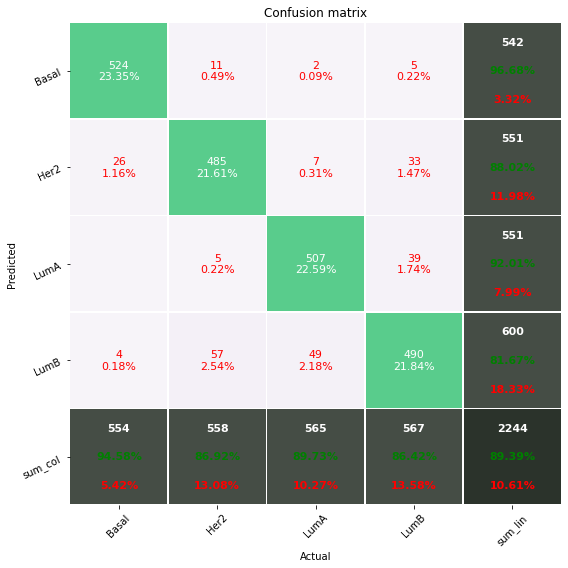

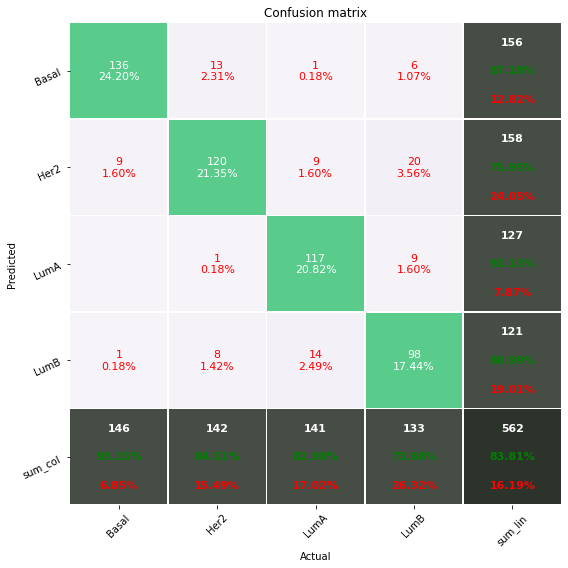

In [25]:
model = Net(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
t0 = time.time()
epochs = 80
loss_ = []
for epoch in range(1, epochs + 1):
    loss, t_acc, t_conf = train(model, criterion, optimizer, X_train, y_train, batch_size=200)
    v_acc, v_conf = val(model, criterion, optimizer, X_test, y_test, batch_size=200)
    loss_.append(loss)
    print(f'| epoch {epoch:03d} | loss={loss:.3f}')
    print(f'    - Training accuracy   = {t_acc:.3f}%')
    print(f'    - Validation accuracy = {v_acc:.3f}% \n')

cm(t_conf)
cm(v_conf)

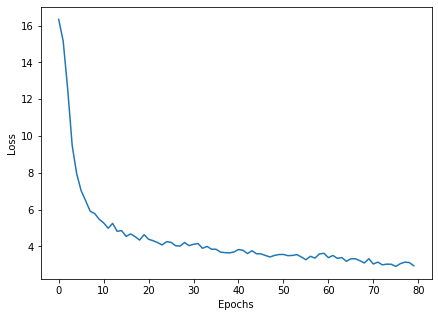

In [70]:
plt.figure(figsize=(7, 5))
plt.plot(loss_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()